# DDoS/DoS Detection System - Training (Kaggle Version)

## Project Overview
This notebook trains a **CNN + BiLSTM + Attention** deep learning model to detect DDoS, DoS, and brute force attacks from network traffic data.

## Dataset: CIC-IDS2018
**Add the dataset in Kaggle:**
1. Click "+ Add data" button (right sidebar)
2. Search for "CIC-IDS2018" or upload your own dataset
3. Dataset will be available in `/kaggle/input/cic-ids2018/`

**Required files (6 files):**

1. **02-14-2018.csv** (~350 MB) - FTP-BruteForce
2. **02-15-2018.csv** (~400 MB) - SSH-Bruteforce
3. **02-16-2018.csv** (~600 MB) - DoS attacks (Hulk, GoldenEye)
4. **02-20-2018.csv** (~4 GB) - DDoS attacks (HOIC, LOIC-HTTP, LOIC-UDP)
5. **02-21-2018.csv** (~600 MB) - DoS attacks (SlowHTTPTest, Slowloris)
6. **02-22-2018.csv** (~600 MB) - Web attacks (Brute Force -Web, -XSS)

**Total Size**: ~6.5-7 GB

## Attack Types to Detect (12 classes)
- Benign (Normal traffic)
- **DDoS**: HOIC, LOIC-HTTP, LOIC-UDP
- **DoS**: Hulk, GoldenEye, SlowHTTPTest, Slowloris
- **Brute Force**: FTP, SSH, Web, XSS

## Expected Training Time
- **GPU P100**: 2-4 hours
- **GPU T4**: 2-4 hours

## Output
- Trained model in multiple formats (.keras, .h5, SavedModel)
- Preprocessing pipeline (scaler, encoder, selector)
- Performance metrics and visualizations
- Ready-to-use Python script (use_model.py)
- Model package saved in `/kaggle/working/` (~20-25 MB)

## Step 1: Check GPU Availability


In [1]:
# Check GPU availability
import tensorflow as tf

print("="*70)
print("GPU AVAILABILITY CHECK")
print("="*70)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPU Available: {len(gpus)} GPU(s) detected")
    for gpu in gpus:
        print(f"   {gpu}")
    print("\nGPU Details:")
    !nvidia-smi --query-gpu=name,memory.total,driver_version --format=csv
else:
    print("\n⚠️ WARNING: No GPU found!")
    print("   Training will be MUCH slower (10-20x slower)")
    print("\n💡 To enable GPU:")
    print("   1. Go to: Settings → Accelerator")
    print("   2. Select: GPU P100 or T4")
    print("   3. Click: Save")
    print("   4. Re-run this cell")

print(f"\nTensorFlow version: {tf.__version__}")
print("="*70)

2025-11-12 09:53:31.015162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762941211.208795      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762941211.265624      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

GPU AVAILABILITY CHECK

✅ GPU Available: 2 GPU(s) detected
   PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
   PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

GPU Details:
name, memory.total [MiB], driver_version
Tesla T4, 15360 MiB, 560.35.03
Tesla T4, 15360 MiB, 560.35.03

TensorFlow version: 2.18.0


## Step 2: Install Dependencies


In [2]:
# Install any missing packages
import sys

print("="*70)
print("INSTALLING DEPENDENCIES")
print("="*70)

# Check and install cpuinfo if needed
try:
    import cpuinfo
    print("✅ py-cpuinfo already installed")
except ImportError:
    print("📦 Installing py-cpuinfo...")
    !pip install -q py-cpuinfo
    print("✅ py-cpuinfo installed")

# Verify key packages
print("\nVerifying packages:")
packages = [
    ('tensorflow', 'TensorFlow'),
    ('numpy', 'NumPy'),
    ('pandas', 'Pandas'),
    ('sklearn', 'Scikit-learn'),
    ('matplotlib', 'Matplotlib'),
    ('seaborn', 'Seaborn')
]

for package, name in packages:
    try:
        exec(f"import {package}")
        version = eval(f"{package}.__version__")
        print(f"  ✅ {name:15s} v{version}")
    except Exception as e:
        print(f"  ❌ {name:15s} Error: {e}")

print("\n✅ All dependencies ready!")
print("="*70)


INSTALLING DEPENDENCIES
✅ py-cpuinfo already installed

Verifying packages:
  ✅ TensorFlow      v2.18.0
  ✅ NumPy           v1.26.4
  ✅ Pandas          v2.2.3
  ✅ Scikit-learn    v1.2.2
  ✅ Matplotlib      v3.7.2
  ✅ Seaborn         v0.12.2

✅ All dependencies ready!


## Step 3: Import All Required Libraries


In [3]:
# Standard libraries
import os
import time
import json
import pickle
import shutil
import warnings
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Bidirectional, LSTM,
    Dense, Dropout, MultiHeadAttention, LayerNormalization,
    GlobalAveragePooling1D, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("✅ All libraries imported successfully!")
print("="*70)


✅ All libraries imported successfully!


## Step 4: Verify Data Files


In [6]:
# Verify all 6 data files exist
data_dir = '/kaggle/input/ids-intrusion-csv/'  # Update this if your dataset name is different
required_files = [
    '02-14-2018.csv',  # FTP-BruteForce
    '02-15-2018.csv',  # SSH-Bruteforce
    '02-16-2018.csv',  # DoS Hulk, GoldenEye
    '02-20-2018.csv',  # DDoS HOIC, LOIC-HTTP, LOIC-UDP
    '02-21-2018.csv',  # DoS SlowHTTPTest, Slowloris
    '02-22-2018.csv',  # Web attacks
]

print("="*70)
print("VERIFYING DATA FILES")
print("="*70)

# Check if data directory exists
if not os.path.exists(data_dir):
    print(f"\n❌ ERROR: Data directory not found: {data_dir}")
    print("\n💡 To fix:")
    print("   1. Click '+ Add data' button (right sidebar)")
    print("   2. Search for 'CIC-IDS2018' or upload your dataset")
    print("   3. Update 'data_dir' variable if dataset name is different")
    print("   4. Re-run this cell")
    raise Exception(f"Data directory not found: {data_dir}")

print(f"\n✅ Data directory exists: {data_dir}")
print(f"\nChecking for {len(required_files)} required files:")

missing_files = []
found_files = []

for filename in required_files:
    filepath = os.path.join(data_dir, filename)
    if os.path.exists(filepath):
        file_size = os.path.getsize(filepath) / (1024 * 1024)  # Convert to MB
        if file_size > 1024:
            size_str = f"{file_size / 1024:.2f} GB"
        else:
            size_str = f"{file_size:.0f} MB"
        print(f"  ✅ {filename:20s} ({size_str})")
        found_files.append(filename)
    else:
        print(f"  ❌ {filename:20s} (MISSING)")
        missing_files.append(filename)

if missing_files:
    print(f"\n❌ ERROR: {len(missing_files)} file(s) missing!")
    print("\nMissing files:")
    for f in missing_files:
        print(f"  - {f}")
    print("\n💡 Add the dataset with all 6 files and re-run this cell")
    raise Exception(f"{len(missing_files)} required files are missing")

print(f"\n✅ All {len(required_files)} files found!")
print("="*70)

VERIFYING DATA FILES

✅ Data directory exists: /kaggle/input/ids-intrusion-csv/

Checking for 6 required files:
  ✅ 02-14-2018.csv       (342 MB)
  ✅ 02-15-2018.csv       (359 MB)
  ✅ 02-16-2018.csv       (318 MB)
  ✅ 02-20-2018.csv       (3.78 GB)
  ✅ 02-21-2018.csv       (314 MB)
  ✅ 02-22-2018.csv       (365 MB)

✅ All 6 files found!


## Step 5: Load Data Files


In [16]:
# Load all data files with special handling for large file
print("="*70)
print("LOADING DATA FILES")
print("="*70)

files_to_load = [
    ('02-14-2018.csv', False),   # FTP-BruteForce
    ('02-15-2018.csv', False),   # SSH-Bruteforce
    ('02-16-2018.csv', False),   # DoS Hulk, GoldenEye
    ('02-20-2018.csv', True),    # DDoS - LARGE FILE (4GB)
    ('02-21-2018.csv', False),   # DoS SlowHTTPTest, Slowloris
    ('02-22-2018.csv', False),   # Web attacks
]

dfs = []
total_start_time = time.time()

for filename, is_large in files_to_load:
    filepath = os.path.join(data_dir, filename)
    print(f"\n📂 Loading: {filename}")
    file_start_time = time.time()
    
    try:
        if is_large:
            # Special handling for large file (02-20-2018.csv - 4GB)
            print("   ⚠️ Large file detected - loading in chunks...")
            print("   This may take 5-10 minutes...")
            
            chunk_list = []
            total_rows = 0
            target_per_class = 50000  # Target samples per class
            
            chunk_iter = pd.read_csv(filepath, chunksize=100000, low_memory=False)
            
            for chunk_num, chunk in enumerate(chunk_iter, 1):
                # Remove Timestamp if exists
                if 'Timestamp' in chunk.columns:
                    chunk = chunk.drop(columns=['Timestamp'])
                
                # Sample from this chunk
                chunk_sampled = chunk.groupby('Label', group_keys=False).apply(
                    lambda x: x.sample(min(len(x), 10000), random_state=42)
                )
                
                chunk_list.append(chunk_sampled)
                total_rows += len(chunk_sampled)
                
                if chunk_num % 5 == 0:
                    print(f"   Progress: Processed {chunk_num} chunks, {total_rows:,} samples so far...")
                
                # Stop after enough samples
                if total_rows >= target_per_class * 4:  # Expect 4 classes in this file
                    print(f"   Reached target samples, stopping at chunk {chunk_num}")
                    break
            
            # Combine chunks
            df_temp = pd.concat(chunk_list, ignore_index=True)
            
            # Final sampling per class
            df_temp = df_temp.groupby('Label', group_keys=False).apply(
                lambda x: x.sample(min(len(x), target_per_class), random_state=42)
            )
            
            print(f"   ✅ Loaded and sampled: {df_temp.shape[0]:,} samples")
            
        else:
            # Regular files - load normally
            df_temp = pd.read_csv(filepath, low_memory=False)
            
            # Remove Timestamp if exists
            if 'Timestamp' in df_temp.columns:  # ✅ FIX: Use df_temp instead of chunk
                df_temp = df_temp.drop(columns=['Timestamp'])
            
            print(f"   ✅ Loaded: {df_temp.shape[0]:,} samples")
        
        # Display attack types in this file
        attack_types = df_temp['Label'].unique()
        print(f"   Attack types: {list(attack_types)}")
        
        dfs.append(df_temp)
        
        file_time = time.time() - file_start_time
        print(f"   Time: {file_time:.1f}s")
        
    except Exception as e:
        print(f"   ❌ Error loading {filename}: {e}")
        import traceback
        traceback.print_exc()
        raise

# Combine all dataframes
if dfs:
    print(f"\n{'='*70}")
    print("COMBINING DATASETS")
    print("="*70)
    
    df = pd.concat(dfs, ignore_index=True)
    
    total_time = time.time() - total_start_time
    
    print(f"\n✅ Successfully loaded {len(dfs)} files")
    print(f"Total samples: {df.shape[0]:,}")
    print(f"Total features: {df.shape[1]}")
    print(f"Total time: {total_time/60:.1f} minutes")
    
    print(f"\nAll attack types ({df['Label'].nunique()} unique):")
    print("="*70)
    for label, count in df['Label'].value_counts().items():
        emoji = "✅" if label == 'Benign' else "🚨"
        print(f"  {emoji} {label:35s}: {count:>8,} samples")
    
    print(f"\n{'='*70}")
    print("✅ Data loading complete!")
    print("="*70)
else:
    raise Exception("No files were loaded successfully!")


LOADING DATA FILES

📂 Loading: 02-14-2018.csv
   ✅ Loaded: 1,048,575 samples
   Attack types: ['Benign', 'FTP-BruteForce', 'SSH-Bruteforce']
   Time: 12.1s

📂 Loading: 02-15-2018.csv
   ✅ Loaded: 1,048,575 samples
   Attack types: ['Benign', 'DoS attacks-GoldenEye', 'DoS attacks-Slowloris']
   Time: 13.3s

📂 Loading: 02-16-2018.csv
   ✅ Loaded: 1,048,575 samples
   Attack types: ['Benign', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk', 'Label']
   Time: 31.5s

📂 Loading: 02-20-2018.csv
   ⚠️ Large file detected - loading in chunks...
   This may take 5-10 minutes...
   Progress: Processed 5 chunks, 51,251 samples so far...
   Progress: Processed 10 chunks, 111,251 samples so far...
   Progress: Processed 15 chunks, 161,251 samples so far...
   Reached target samples, stopping at chunk 19
   ✅ Loaded and sampled: 100,000 samples
   Attack types: ['Benign', 'DDoS attacks-LOIC-HTTP']
   Time: 23.3s

📂 Loading: 02-21-2018.csv
   ✅ Loaded: 1,048,575 samples
   Attack types: ['Benign', 'DDO

## Step 6: Sample Data Per Class


In [18]:
# Sample data to create balanced dataset
print("="*70)
print("SAMPLING DATA")
print("="*70)

# Calculate samples per class based on number of classes
num_classes = df['Label'].nunique()
print(f"\nNumber of classes: {num_classes}")

# Adjust sampling based on class count
if num_classes <= 5:
    samples_per_class = 50000
elif num_classes <= 10:
    samples_per_class = 40000
else:
    samples_per_class = 30000

print(f"Target samples per class: {samples_per_class:,}")
print(f"Expected total: ~{samples_per_class * num_classes:,} samples")

# Sample from each class
df_sampled = df.groupby('Label', group_keys=False).apply(
    lambda x: x.sample(min(len(x), samples_per_class), random_state=42)
)

print(f"\n✅ Sampled dataset: {df_sampled.shape[0]:,} samples")
print(f"\nDistribution after sampling:")
print("="*70)

for label, count in df_sampled['Label'].value_counts().sort_index().items():
    emoji = "✅" if label == 'Benign' else "🚨"
    print(f"  {emoji} {label:35s}: {count:>8,} samples")

# Update df
df = df_sampled

print(f"\n{'='*70}")
print("✅ Sampling complete!")
print("="*70)


SAMPLING DATA

Number of classes: 14
Target samples per class: 30,000
Expected total: ~420,000 samples

✅ Sampled dataset: 253,083 samples

Distribution after sampling:
  ✅ Benign                             :   30,000 samples
  🚨 Brute Force -Web                   :      249 samples
  🚨 Brute Force -XSS                   :       79 samples
  🚨 DDOS attack-HOIC                   :   30,000 samples
  🚨 DDOS attack-LOIC-UDP               :    1,730 samples
  🚨 DDoS attacks-LOIC-HTTP             :   30,000 samples
  🚨 DoS attacks-GoldenEye              :   30,000 samples
  🚨 DoS attacks-Hulk                   :   30,000 samples
  🚨 DoS attacks-SlowHTTPTest           :   30,000 samples
  🚨 DoS attacks-Slowloris              :   10,990 samples
  🚨 FTP-BruteForce                     :   30,000 samples
  🚨 Label                              :        1 samples
  🚨 SQL Injection                      :       34 samples
  🚨 SSH-Bruteforce                     :   30,000 samples

✅ Sampling complet

## Step 7: Clean Data


In [19]:
# Clean data: encode labels, convert to numeric, remove inf/NaN
print("="*70)
print("CLEANING DATA")
print("="*70)

# Validate data exists
if df.shape[0] == 0:
    raise Exception("❌ ERROR: DataFrame is empty! Re-run data loading cells (Cell 10).")

print(f"\nInitial dataset: {df.shape[0]:,} samples, {df.shape[1]} features")

# Step 1: Remove header row if Label column contains "Label" as a value
print(f"\n🔄 Step 1: Removing header rows...")
before_header = df.shape[0]

if 'Label' in df.columns:
    # Remove rows where Label is the string "Label"
    if df['Label'].dtype == 'object':
        df = df[df['Label'].astype(str).str.strip() != 'Label']
    # Remove empty/null labels
    df = df[df['Label'].notna()]
    df = df[df['Label'].astype(str).str.strip() != '']
    
    header_removed = before_header - df.shape[0]
    if header_removed > 0:
        print(f"✅ Removed {header_removed:,} header/invalid row(s)")
    else:
        print("✅ No header rows found")
else:
    raise Exception("❌ ERROR: 'Label' column not found!")

if df.shape[0] == 0:
    raise Exception("❌ ERROR: All rows removed during header cleanup!")

print(f"After header removal: {df.shape[0]:,} samples")

# Step 2: Encode labels (do this BEFORE converting to numeric)
print(f"\n🔄 Step 2: Encoding labels...")
encoder = LabelEncoder()
df['Label'] = encoder.fit_transform(df['Label'].astype(str))

print(f"✅ Labels encoded")
print(f"Class mapping:")
for idx, class_name in enumerate(encoder.classes_):
    emoji = "✅" if class_name == 'Benign' else "🚨"
    print(f"  {idx:2d}. {emoji} {class_name}")

# Step 3: Get feature columns (exclude Label)
feature_cols = [col for col in df.columns if col != 'Label']
print(f"\nFeature columns: {len(feature_cols)}")

# Step 4: Convert feature columns to numeric (NOT Label column)
print(f"\n🔄 Step 3: Converting features to numeric...")
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"✅ Features converted to numeric")

# Step 5: Handle inf values (replace with NaN)
print(f"\n🔄 Step 4: Handling inf values...")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
inf_count = df[feature_cols].isnull().sum().sum()
print(f"✅ Replaced inf with NaN: {inf_count:,} values in features")

# Step 6: Remove rows where ALL features are NaN (but keep rows with some NaN)
print(f"\n🔄 Step 5: Removing rows with all features NaN...")
before_all_nan = df.shape[0]
df = df.dropna(subset=feature_cols, how='all')  # Only drop if ALL features are NaN
after_all_nan = df.shape[0]
all_nan_removed = before_all_nan - after_all_nan

if all_nan_removed > 0:
    print(f"✅ Removed {all_nan_removed:,} rows where ALL features were NaN")
else:
    print("✅ No rows with all NaN features")

if df.shape[0] == 0:
    raise Exception("❌ ERROR: All rows removed! Check your data format.")

# Step 7: Fill remaining NaN with 0 (safer than removing rows)
print(f"\n🔄 Step 6: Filling remaining NaN values with 0...")
df[feature_cols] = df[feature_cols].fillna(0)
remaining_nan = df[feature_cols].isnull().sum().sum()
print(f"✅ Filled NaN values. Remaining NaN: {remaining_nan:,}")

# Final validation
if df.shape[0] == 0:
    raise Exception("❌ ERROR: All rows removed during cleaning! Check your data format.")

print(f"\n✅ Final cleaned dataset: {df.shape[0]:,} samples, {df.shape[1]} features")
print(f"   Classes: {df['Label'].nunique()}")

# Show final label distribution
print(f"\nFinal label distribution:")
for label_idx, count in df['Label'].value_counts().sort_index().items():
    label_name = encoder.classes_[label_idx]
    emoji = "✅" if label_name == 'Benign' else "🚨"
    print(f"  {emoji} {label_name:35s}: {count:>8,} samples")

print(f"\n{'='*70}")
print("✅ Data cleaning complete!")
print("="*70)

CLEANING DATA

Initial dataset: 253,083 samples, 83 features

🔄 Step 1: Removing header rows...
✅ Removed 1 header/invalid row(s)
After header removal: 253,082 samples

🔄 Step 2: Encoding labels...
✅ Labels encoded
Class mapping:
   0. ✅ Benign
   1. 🚨 Brute Force -Web
   2. 🚨 Brute Force -XSS
   3. 🚨 DDOS attack-HOIC
   4. 🚨 DDOS attack-LOIC-UDP
   5. 🚨 DDoS attacks-LOIC-HTTP
   6. 🚨 DoS attacks-GoldenEye
   7. 🚨 DoS attacks-Hulk
   8. 🚨 DoS attacks-SlowHTTPTest
   9. 🚨 DoS attacks-Slowloris
  10. 🚨 FTP-BruteForce
  11. 🚨 SQL Injection
  12. 🚨 SSH-Bruteforce

Feature columns: 82

🔄 Step 3: Converting features to numeric...
✅ Features converted to numeric

🔄 Step 4: Handling inf values...
✅ Replaced inf with NaN: 982,174 values in features

🔄 Step 5: Removing rows with all features NaN...
✅ No rows with all NaN features

🔄 Step 6: Filling remaining NaN values with 0...
✅ Filled NaN values. Remaining NaN: 0

✅ Final cleaned dataset: 253,082 samples, 83 features
   Classes: 13

Final lab

## Step 8: Preprocess and Split Data


In [20]:
# Preprocess data: feature selection, scaling, train/test split
print("="*70)
print("PREPROCESSING DATA")
print("="*70)

# Separate features and labels
X = df.drop('Label', axis=1).values
y = df['Label'].values

num_classes = len(np.unique(y))
print(f"\nDataset shape: {X.shape}")
print(f"Number of classes: {num_classes}")

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ Train/test split:")
print(f"   Training: {X_train.shape[0]:,} samples")
print(f"   Testing:  {X_test.shape[0]:,} samples")

# Feature selection (remove low variance features)
print(f"\n🔄 Selecting features...")
selector = VarianceThreshold(threshold=0.01)
X_train_selected = selector.fit_transform(X_train)
X_test_selected = selector.transform(X_test)

selected_features = X_train_selected.shape[1]
print(f"✅ Features after selection: {selected_features} (removed {X_train.shape[1] - selected_features})")

# Scale features
print(f"\n🔄 Scaling features...")
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

print(f"✅ Features scaled")

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"✅ Labels one-hot encoded: {y_train_cat.shape}")

# Prepare 3D data for CNN (samples, features, 1)
X_train_cnn = X_train_scaled[..., np.newaxis]
X_test_cnn = X_test_scaled[..., np.newaxis]

print(f"\n✅ Data prepared for CNN:")
print(f"   Training shape: {X_train_cnn.shape}")
print(f"   Testing shape:  {X_test_cnn.shape}")

print(f"\n{'='*70}")
print("✅ Preprocessing complete!")
print("="*70)


PREPROCESSING DATA

Dataset shape: (253082, 82)
Number of classes: 13

✅ Train/test split:
   Training: 202,465 samples
   Testing:  50,617 samples

🔄 Selecting features...
✅ Features after selection: 68 (removed 14)

🔄 Scaling features...
✅ Features scaled
✅ Labels one-hot encoded: (202465, 13)

✅ Data prepared for CNN:
   Training shape: (202465, 68, 1)
   Testing shape:  (50617, 68, 1)

✅ Preprocessing complete!


## Step 9: Build CNN + BiLSTM + Attention Model


In [21]:
# Build CNN + BiLSTM + Multi-Head Attention model
print("="*70)
print("BUILDING MODEL")
print("="*70)

input_shape = (X_train_cnn.shape[1], 1)
print(f"\nInput shape: {input_shape}")
print(f"Number of classes: {num_classes}")

# Input layer
inputs = Input(shape=input_shape, name='input')

# CNN layers for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv1')(inputs)
x = MaxPooling1D(pool_size=2, name='pool1')(x)
x = Dropout(0.3, name='dropout1')(x)

x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', name='conv2')(x)
x = MaxPooling1D(pool_size=2, name='pool2')(x)
x = Dropout(0.3, name='dropout2')(x)

# BiLSTM layers for temporal patterns
x = Bidirectional(LSTM(64, return_sequences=True, name='lstm1'), name='bilstm1')(x)
x = Dropout(0.3, name='dropout3')(x)

x = Bidirectional(LSTM(32, return_sequences=True, name='lstm2'), name='bilstm2')(x)

# Multi-Head Attention
attention_output = MultiHeadAttention(
    num_heads=4,
    key_dim=32,
    name='multihead_attention'
)(x, x)

# Combine attention with original
x = LayerNormalization(name='layer_norm')(attention_output + x)
x = Dropout(0.3, name='dropout4')(x)

# Global pooling
x = GlobalAveragePooling1D(name='global_pool')(x)

# Dense layers
x = Dense(128, activation='relu', name='dense1')(x)
x = Dropout(0.4, name='dropout5')(x)

x = Dense(64, activation='relu', name='dense2')(x)
x = Dropout(0.4, name='dropout6')(x)

# Output layer
outputs = Dense(num_classes, activation='softmax', name='output')(x)

# Create model
attn_model = Model(inputs=inputs, outputs=outputs, name='CNN_BiLSTM_Attention')

print(f"\n✅ Model built successfully!")
print(f"\nModel architecture:")
print("="*70)
attn_model.summary()
print("="*70)


BUILDING MODEL

Input shape: (68, 1)
Number of classes: 13


I0000 00:00:1762942688.171569      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762942688.172237      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



✅ Model built successfully!

Model architecture:


Model: "CNN_BiLSTM_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 68, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv1D)      │ (None, 68, 64)    │        256 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 34, 64)    │          0 │ conv1[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 34, 64)    │          0 │ pool1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv1D)      │ (None, 34, 128)   │     24,704 │ dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 17, 128)   │          0 │ conv2[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout2 (Dropout)  │ (None, 17, 128)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm1             │ (None, 17, 128)   │     98,816 │ dropout2[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout3 (Dropout)  │ (None, 17, 128)   │          0 │ bilstm1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm2             │ (None, 17, 64)    │     41,216 │ dropout3[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attention │ (None, 17, 64)    │     33,216 │ bilstm2[0][0],    │
│ (MultiHeadAttentio… │                   │            │ bilstm2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 17, 64)    │          0 │ multihead_attent… │
│                     │                   │            │ bilstm2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm          │ (None, 17, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout4 (Dropout)  │ (None, 17, 64)    │          0 │ layer_norm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_pool         │ (None, 64)        │          0 │ dropout4[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 128)       │      8,320 │ global_pool[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout5 (Dropout)  │ (None, 128)       │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 64)        │      8,256 │ dropout5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout6 (Dropout)  │ (None, 64)        │          0 │ dense2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 13)        │        845 │ dropout6[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 215,757 (842.80 KB)

 Trainable params: 215,757 (842.80 KB)

 Non-trainable params: 0 (0.00 B)

## Step 10: Compile Model


In [22]:
# Compile model
print("="*70)
print("COMPILING MODEL")
print("="*70)

attn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

print("\n✅ Model compiled successfully!")
print(f"   Optimizer: Adam (lr=1e-4)")
print(f"   Loss: categorical_crossentropy")
print(f"   Metrics: accuracy, precision, recall")
print("="*70)


COMPILING MODEL

✅ Model compiled successfully!
   Optimizer: Adam (lr=1e-4)
   Loss: categorical_crossentropy
   Metrics: accuracy, precision, recall


## Step 11: Train Model


In [23]:
# Train model with callbacks
print("="*70)
print("TRAINING MODEL")
print("="*70)

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

terminate_on_nan = callbacks.TerminateOnNaN()

print("\n✅ Callbacks configured:")
print("   - EarlyStopping (patience=10)")
print("   - ReduceLROnPlateau (patience=5)")
print("   - TerminateOnNaN")

# Training configuration
batch_size = 256
epochs = 50

print(f"\n🔄 Training configuration:")
print(f"   Batch size: {batch_size}")
print(f"   Max epochs: {epochs}")
print(f"   Training samples: {X_train_cnn.shape[0]:,}")

print(f"\n{'='*70}")
print("TRAINING STARTED")
print("="*70)
print("This will take 2-4 hours on GPU T4...")
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

# Start training
training_start_time = time.time()

history = attn_model.fit(
    X_train_cnn, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, terminate_on_nan],
    verbose=1
)

training_time = time.time() - training_start_time

print(f"\n{'='*70}")
print("✅ TRAINING COMPLETE!")
print("="*70)
print(f"Training time: {training_time/3600:.2f} hours ({training_time/60:.1f} minutes)")
print(f"Finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)


TRAINING MODEL

✅ Callbacks configured:
   - EarlyStopping (patience=10)
   - ReduceLROnPlateau (patience=5)
   - TerminateOnNaN

🔄 Training configuration:
   Batch size: 256
   Max epochs: 50
   Training samples: 202,465

TRAINING STARTED
This will take 2-4 hours on GPU T4...
Started at: 2025-11-12 10:20:04
Epoch 1/50


I0000 00:00:1762942811.262239     158 cuda_dnn.cc:529] Loaded cuDNN version 90300


633/633 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.2965 - loss: 1.9427 - precision: 0.4594 - recall: 0.0941 - val_accuracy: 0.7009 - val_loss: 0.6718 - val_precision: 0.7925 - val_recall: 0.5989 - learning_rate: 1.0000e-04
Epoch 2/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6433 - loss: 0.8486 - precision: 0.6901 - recall: 0.5464 - val_accuracy: 0.8280 - val_loss: 0.4564 - val_precision: 0.8488 - val_recall: 0.8242 - learning_rate: 1.0000e-04
Epoch 3/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7619 - loss: 0.5916 - precision: 0.7896 - recall: 0.7189 - val_accuracy: 0.8548 - val_loss: 0.3299 - val_precision: 0.8604 - val_recall: 0.8411 - learning_rate: 1.0000e-04
Epoch 4/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8197 - loss: 0.4463 - precision: 0.8379 - recall: 0.7931 - val_accuracy: 0.8603 - val_loss: 0.2890 - val_precision: 0.8673 - val_recall: 0.8575 - learning_rate: 1.0000e-04
Epoch 5/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/st

## Step 12: Evaluate Model


EVALUATING MODEL

🔄 Making predictions on test set...

OVERALL METRICS
  Accuracy:  0.9183 (91.83%)
  Precision: 0.9474 (94.74%)
  Recall:    0.9183 (91.83%)
  F1-Score:  0.9085 (90.85%)

PER-CLASS METRICS
                          precision    recall  f1-score   support

                  Benign     0.9919    0.9963    0.9941      6000
        Brute Force -Web     0.6226    0.6600    0.6408        50
        Brute Force -XSS     0.0000    0.0000    0.0000        16
        DDOS attack-HOIC     0.9990    1.0000    0.9995      6000
    DDOS attack-LOIC-UDP     0.9719    1.0000    0.9858       346
  DDoS attacks-LOIC-HTTP     0.9995    0.9982    0.9988      6000
   DoS attacks-GoldenEye     0.9990    0.9992    0.9991      6000
        DoS attacks-Hulk     0.9997    0.9995    0.9996      6000
DoS attacks-SlowHTTPTest     0.5989    0.9923    0.7470      6000
   DoS attacks-Slowloris     0.9973    0.9904    0.9938      2198
          FTP-BruteForce     0.9777    0.3358    0.4999      6000
 

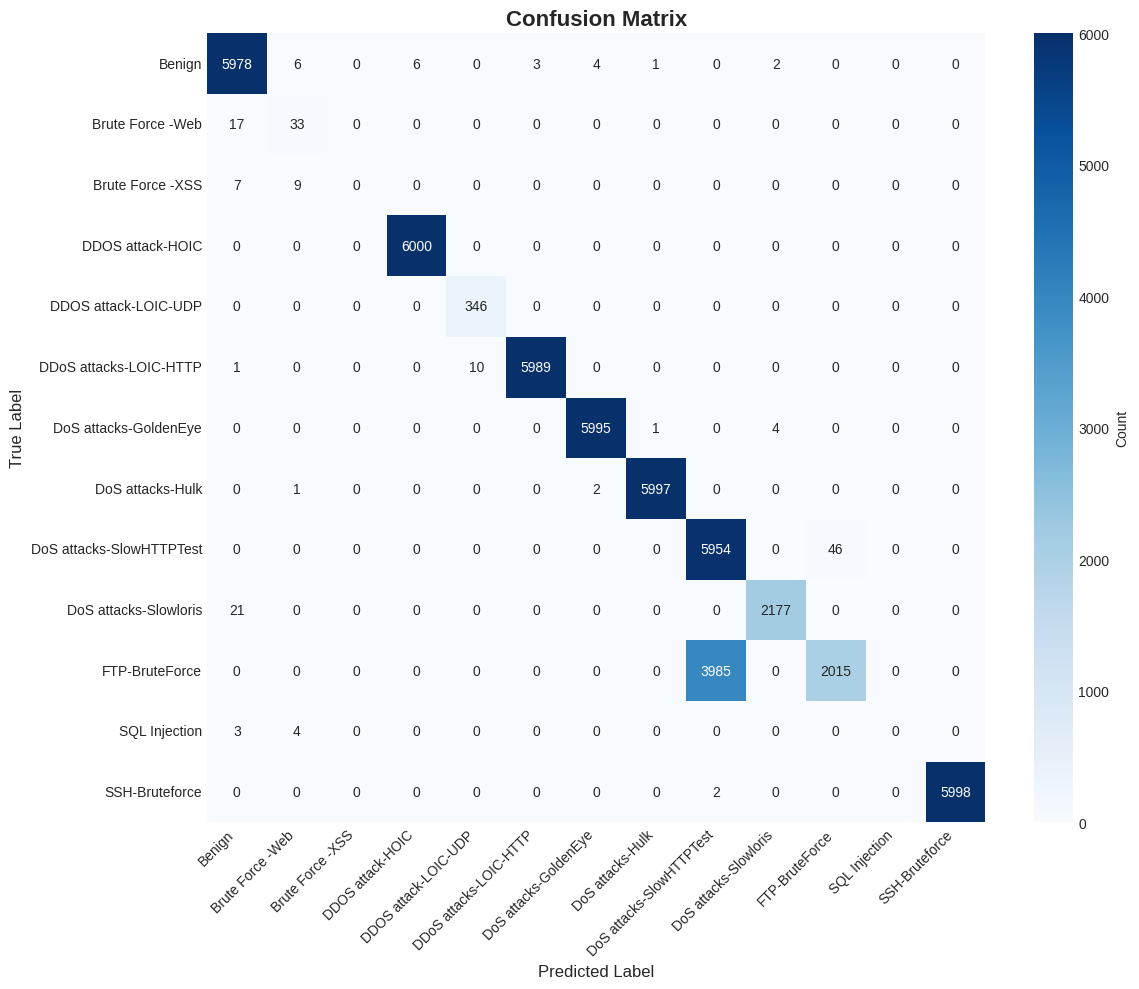


✅ Evaluation complete!


In [24]:
# Evaluate model on test set
print("="*70)
print("EVALUATING MODEL")
print("="*70)

# Predictions
print("\n🔄 Making predictions on test set...")
y_pred_probs = attn_model.predict(X_test_cnn, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\n{'='*70}")
print("OVERALL METRICS")
print("="*70)
print(f"  Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
print(f"  Precision: {prec:.4f} ({prec*100:.2f}%)")
print(f"  Recall:    {rec:.4f} ({rec*100:.2f}%)")
print(f"  F1-Score:  {f1:.4f} ({f1*100:.2f}%)")

# Per-class classification report
print(f"\n{'='*70}")
print("PER-CLASS METRICS")
print("="*70)
print(classification_report(
    y_test, y_pred,
    target_names=encoder.classes_,
    digits=4,
    zero_division=0
))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(f"\n{'='*70}")
print("CONFUSION MATRIX")
print("="*70)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save confusion matrix
confusion_matrix_path = '/kaggle/working/confusion_matrix.png'
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Confusion matrix saved: {confusion_matrix_path}")

plt.show()

print(f"\n{'='*70}")
print("✅ Evaluation complete!")
print("="*70)


## Step 13: Plot Training History


PLOTTING TRAINING HISTORY

✅ Training history saved: /kaggle/working/training_history.png


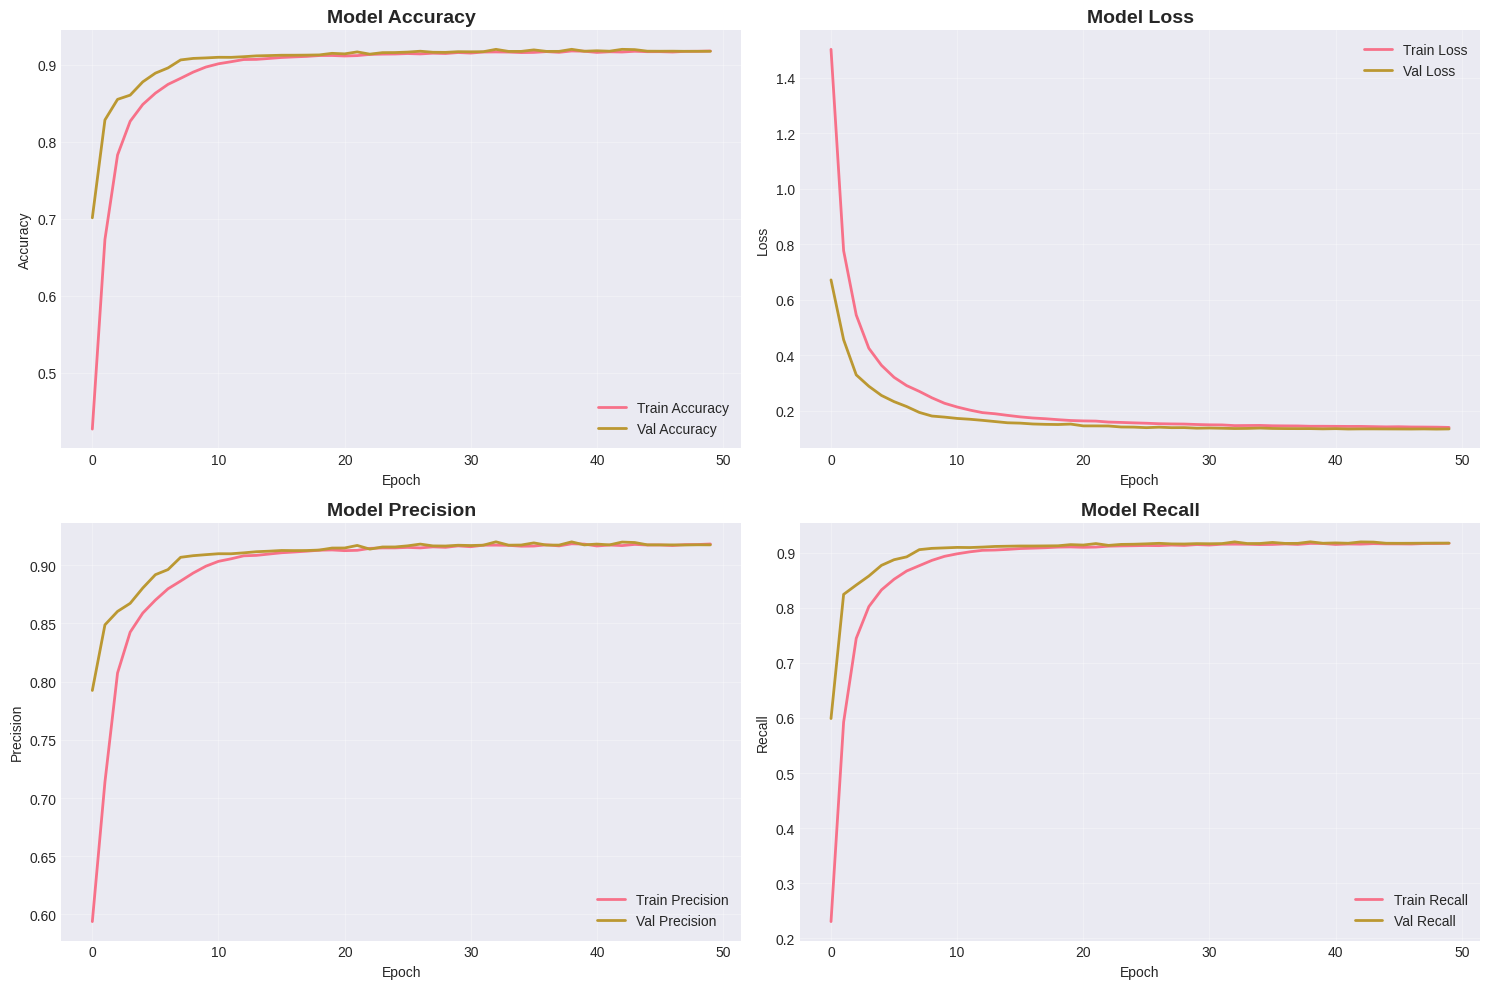


✅ Plotting complete!


In [25]:
# Plot training history
print("="*70)
print("PLOTTING TRAINING HISTORY")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

# Save training history plot
history_plot_path = '/kaggle/working/training_history.png'
plt.savefig(history_plot_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Training history saved: {history_plot_path}")

plt.show()

print(f"\n{'='*70}")
print("✅ Plotting complete!")
print("="*70)


## Step 14: Save Model and Components


In [26]:
# Save model in multiple formats and all preprocessing components
print("="*70)
print("SAVING MODEL AND COMPONENTS")
print("="*70)

# Create output directory
model_dir = '/kaggle/working/model_files_ddos'
os.makedirs(model_dir, exist_ok=True)
print(f"\n✅ Created directory: {model_dir}")

# 1. Save model in .keras format (Keras 3 native)
print("\n🔄 Saving model in .keras format...")
keras_path = os.path.join(model_dir, 'ids_model.keras')
attn_model.save(keras_path)
print(f"✅ Saved: ids_model.keras")

# 2. Save model in .h5 format (backward compatible)
print("\n🔄 Saving model in .h5 format...")
h5_path = os.path.join(model_dir, 'ids_model.h5')
attn_model.save(h5_path)
print(f"✅ Saved: ids_model.h5")

# 3. Save model in SavedModel format
print("\n🔄 Exporting as SavedModel format...")
savedmodel_path = os.path.join(model_dir, 'ids_model_savedmodel')
attn_model.export(savedmodel_path)
print(f"✅ Exported: ids_model_savedmodel/")

# 4. Save preprocessing objects
print("\n🔄 Saving preprocessing objects...")
with open(os.path.join(model_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Saved: scaler.pkl")

with open(os.path.join(model_dir, 'encoder.pkl'), 'wb') as f:
    pickle.dump(encoder, f)
print(f"✅ Saved: encoder.pkl")

with open(os.path.join(model_dir, 'selector.pkl'), 'wb') as f:
    pickle.dump(selector, f)
print(f"✅ Saved: selector.pkl")

# 5. Save metadata
print("\n🔄 Creating metadata...")
metadata = {
    'model_type': 'CNN_BiLSTM_Attention',
    'num_classes': int(num_classes),
    'class_names': list(encoder.classes_),
    'feature_count': int(X_train_selected.shape[1]),
    'input_shape': list(X_train_cnn.shape[1:]),
    'training_date': datetime.now().isoformat(),
    'training_time_hours': float(training_time / 3600),
    'metrics': {
        'accuracy': float(acc),
        'precision': float(prec),
        'recall': float(rec),
        'f1_score': float(f1)
    },
    'training_config': {
        'batch_size': batch_size,
        'epochs_trained': len(history.history['loss']),
        'max_epochs': epochs
    }
}

with open(os.path.join(model_dir, 'model_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Saved: model_metadata.json")


SAVING MODEL AND COMPONENTS

✅ Created directory: /kaggle/working/model_files_ddos

🔄 Saving model in .keras format...
✅ Saved: ids_model.keras

🔄 Saving model in .h5 format...
✅ Saved: ids_model.h5

🔄 Exporting as SavedModel format...
INFO:tensorflow:Assets written to: /kaggle/working/model_files_ddos/ids_model_savedmodel/assets


INFO:tensorflow:Assets written to: /kaggle/working/model_files_ddos/ids_model_savedmodel/assets


Saved artifact at '/kaggle/working/model_files_ddos/ids_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 68, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 13), dtype=tf.float32, name=None)
Captures:
  132734460274704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132734460276816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132734360910736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132734360908816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132734360906128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132734360905552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132734360904976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132734360905168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132734360905360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132734360901136: TensorSpec(shape=(), dtype=tf.resource, na

In [27]:
# Continue saving: create use_model.py and requirements.txt
# 6. Create use_model.py script
print("\n🔄 Creating use_model.py...")
use_model_script = '''# use_model.py - DDoS/DoS Detection Model
import numpy as np
import pandas as pd
import pickle
import json
from tensorflow import keras
import tensorflow as tf
import os

class IDSModel:
    def __init__(self, model_dir='.'):
        """Initialize IDS model with all components"""
        print("Loading DDoS/DoS Detection Model...")
        
        # Try loading model in order of preference
        keras_path = os.path.join(model_dir, 'ids_model.keras')
        savedmodel_path = os.path.join(model_dir, 'ids_model_savedmodel')
        h5_path = os.path.join(model_dir, 'ids_model.h5')
        
        model_loaded = False
        
        # Try .keras format first (Keras 3 native)
        if os.path.exists(keras_path):
            try:
                self.model = keras.models.load_model(keras_path)
                print(f"✅ Model loaded (.keras format)")
                model_loaded = True
            except Exception as e:
                print(f"⚠️  .keras load failed: {str(e)[:100]}")
        
        # Try SavedModel format
        if os.path.exists(savedmodel_path) and not model_loaded:
            try:
                saved_model = tf.saved_model.load(savedmodel_path)
                self.model = saved_model.signatures['serve']
                print(f"✅ Model loaded (SavedModel format)")
                model_loaded = True
                self.model_type = 'savedmodel'
            except Exception as e:
                print(f"⚠️  SavedModel load failed: {str(e)[:100]}")
        
        # Try .h5 format
        if os.path.exists(h5_path) and not model_loaded:
            try:
                self.model = keras.models.load_model(h5_path, compile=False)
                self.model.compile(
                    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )
                print(f"✅ Model loaded (.h5 format)")
                model_loaded = True
            except Exception as e:
                print(f"⚠️  .h5 load failed: {str(e)[:100]}")
        
        if not model_loaded:
            raise Exception("Could not load model in any format!")
        
        if not hasattr(self, 'model_type'):
            self.model_type = 'keras_model'
        
        # Load preprocessing objects
        with open(os.path.join(model_dir, 'scaler.pkl'), 'rb') as f:
            self.scaler = pickle.load(f)
        print("✅ Scaler loaded")
        
        with open(os.path.join(model_dir, 'encoder.pkl'), 'rb') as f:
            self.encoder = pickle.load(f)
        print("✅ Encoder loaded")
        
        with open(os.path.join(model_dir, 'selector.pkl'), 'rb') as f:
            self.selector = pickle.load(f)
        print("✅ Selector loaded")
        
        # Load metadata
        with open(os.path.join(model_dir, 'model_metadata.json'), 'r') as f:
            self.metadata = json.load(f)
        
        self.class_names = self.metadata['class_names']
        print(f"✅ Model ready! Detects {len(self.class_names)} attack types")
    
    def predict(self, features_df):
        """Make predictions on new data"""
        # Remove Label column if present
        if 'Label' in features_df.columns:
            X = features_df.drop('Label', axis=1)
        else:
            X = features_df
        
        # Apply preprocessing
        X_selected = self.selector.transform(X)
        X_scaled = self.scaler.transform(X_selected)
        X_cnn = X_scaled[..., np.newaxis]
        
        # Predict
        if self.model_type == 'savedmodel':
            probabilities = self.model(tf.constant(X_cnn, dtype=tf.float32)).numpy()
        else:
            probabilities = self.model.predict(X_cnn, verbose=0)
        
        # Get predicted classes
        predicted_indices = np.argmax(probabilities, axis=1)
        predictions = [self.class_names[idx] for idx in predicted_indices]
        
        return predictions, probabilities

# Example usage
if __name__ == "__main__":
    # Load model
    ids = IDSModel('.')
    
    # Example: Make predictions (replace with your data)
    # test_data = pd.read_csv('test_data.csv')
    # predictions, probabilities = ids.predict(test_data)
    # print(f"Predictions: {predictions}")
'''

with open(os.path.join(model_dir, 'use_model.py'), 'w') as f:
    f.write(use_model_script)
print(f"✅ Saved: use_model.py")

# 7. Create requirements.txt
print("\n🔄 Creating requirements.txt...")
requirements = """tensorflow>=2.13.0
pandas>=1.5.0
numpy>=1.23.0
scikit-learn>=1.2.0
matplotlib>=3.5.0
seaborn>=0.12.0
"""

with open(os.path.join(model_dir, 'requirements.txt'), 'w') as f:
    f.write(requirements)
print(f"✅ Saved: requirements.txt")

# 8. Copy visualization images
print("\n🔄 Copying visualizations...")
if os.path.exists('/kaggle/working/confusion_matrix.png'):
    shutil.copy('/kaggle/working/confusion_matrix.png', os.path.join(model_dir, 'confusion_matrix.png'))
    print(f"✅ Copied: confusion_matrix.png")

if os.path.exists('/kaggle/working/training_history.png'):
    shutil.copy('/kaggle/working/training_history.png', os.path.join(model_dir, 'training_history.png'))
    print(f"✅ Copied: training_history.png")

# 9. Create ZIP file
print("\n🔄 Creating ZIP package...")
zip_path = '/kaggle/working/ids_ddos_model.zip'
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', model_dir)
zip_size = os.path.getsize(zip_path) / (1024 * 1024)
print(f"✅ Created: ids_ddos_model.zip ({zip_size:.2f} MB)")

# Display summary
print(f"\n{'='*70}")
print("📦 MODEL PACKAGE CONTENTS")
print("="*70)
for root, dirs, files in os.walk(model_dir):
    for file in files:
        filepath = os.path.join(root, file)
        size = os.path.getsize(filepath)
        rel_path = os.path.relpath(filepath, model_dir)
        if size > 1024 * 1024:
            print(f"  📄 {rel_path:40s} ({size / 1024 / 1024:.2f} MB)")
        else:
            print(f"  📄 {rel_path:40s} ({size / 1024:.2f} KB)")

print(f"\n{'='*70}")
print("✅ ALL FILES SAVED SUCCESSFULLY!")
print("="*70)



🔄 Creating use_model.py...
✅ Saved: use_model.py

🔄 Creating requirements.txt...
✅ Saved: requirements.txt

🔄 Copying visualizations...
✅ Copied: confusion_matrix.png
✅ Copied: training_history.png

🔄 Creating ZIP package...
✅ Created: ids_ddos_model.zip (6.88 MB)

📦 MODEL PACKAGE CONTENTS
  📄 use_model.py                             (4.22 KB)
  📄 requirements.txt                         (0.10 KB)
  📄 selector.pkl                             (0.94 KB)
  📄 confusion_matrix.png                     (482.50 KB)
  📄 scaler.pkl                               (1.45 KB)
  📄 encoder.pkl                              (0.49 KB)
  📄 ids_model.keras                          (2.59 MB)
  📄 model_metadata.json                      (0.80 KB)
  📄 training_history.png                     (371.07 KB)
  📄 ids_model.h5                             (2.58 MB)
  📄 ids_model_savedmodel/fingerprint.pb      (0.06 KB)
  📄 ids_model_savedmodel/saved_model.pb      (312.75 KB)
  📄 ids_model_savedmodel/variables/variabl

## Step 15: Test Model Loading


In [28]:
# Test model loading using use_model.py
print("="*70)
print("TESTING MODEL LOADING")
print("="*70)

# Import the IDSModel class
import sys
sys.path.insert(0, model_dir)
from use_model import IDSModel

try:
    # Load model
    print("\n🔄 Loading model...")
    ids = IDSModel(model_dir)
    
    print(f"\n✅ Model loaded successfully!")
    print(f"\nModel info:")
    print(f"  Model type: {ids.metadata['model_type']}")
    print(f"  Classes: {len(ids.class_names)}")
    print(f"  Feature count: {ids.metadata['feature_count']}")
    
    # Test prediction on a few samples
    print(f"\n🔄 Testing predictions on {min(5, len(X_test))} samples...")
    
    # Get original features for test samples (before preprocessing)
    test_indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)
    test_samples = X_test[test_indices]
    
    # Create DataFrame
    test_df = pd.DataFrame(test_samples)
    
    # Make predictions
    predictions, probabilities = ids.predict(test_df)
    
    print(f"\n✅ Predictions successful!")
    print(f"\nSample predictions:")
    print("="*70)
    for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
        true_label = encoder.classes_[y_test[test_indices[i]]]
        confidence = max(prob) * 100
        print(f"Sample {i+1}:")
        print(f"  True: {true_label:30s} | Predicted: {pred:30s}")
        print(f"  Confidence: {confidence:.2f}%")
        print()
    
    print("="*70)
    print("✅ MODEL LOADING TEST COMPLETE!")
    print("="*70)
    
except Exception as e:
    print(f"\n❌ Error during testing: {e}")
    import traceback
    traceback.print_exc()


TESTING MODEL LOADING

🔄 Loading model...
Loading DDoS/DoS Detection Model...
✅ Model loaded (.keras format)
✅ Scaler loaded
✅ Encoder loaded
✅ Selector loaded
✅ Model ready! Detects 13 attack types

✅ Model loaded successfully!

Model info:
  Model type: CNN_BiLSTM_Attention
  Classes: 13
  Feature count: 68

🔄 Testing predictions on 5 samples...

✅ Predictions successful!

Sample predictions:
Sample 1:
  True: DoS attacks-Slowloris          | Predicted: DoS attacks-Slowloris         
  Confidence: 100.00%

Sample 2:
  True: DoS attacks-Hulk               | Predicted: DoS attacks-Hulk              
  Confidence: 100.00%

Sample 3:
  True: FTP-BruteForce                 | Predicted: DoS attacks-SlowHTTPTest      
  Confidence: 51.99%

Sample 4:
  True: SSH-Bruteforce                 | Predicted: SSH-Bruteforce                
  Confidence: 100.00%

Sample 5:
  True: DoS attacks-Hulk               | Predicted: DoS attacks-Hulk              
  Confidence: 100.00%

✅ MODEL LOADING TEST CO

## Step 16: Download Model Package


In [29]:
# Model package saved - Ready for download
print("="*70)
print("MODEL PACKAGE SAVED")
print("="*70)

print(f"\n✅ Model package saved: {zip_path}")
print(f"   Size: {os.path.getsize(zip_path) / (1024 * 1024):.2f} MB")

print(f"\n📥 TO DOWNLOAD:")
print("   1. Go to: Output tab (right sidebar)")
print("   2. Find: ids_ddos_model.zip")
print("   3. Click: Three dots → Download")
print("\n   OR wait until notebook completes, then download from Output")

print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("""
1. EXTRACT THE ZIP FILE
   Extract ids_ddos_model.zip on your local machine

2. INSTALL DEPENDENCIES
   cd <extracted_folder>
   pip install -r requirements.txt

3. USE THE MODEL
   python use_model.py
   
   Or in your code:
   from use_model import IDSModel
   ids = IDSModel('.')
   predictions, probs = ids.predict(your_data)

4. MODEL PERFORMANCE
   - Accuracy:  {acc:.2%}
   - Precision: {prec:.2%}
   - Recall:    {rec:.2%}
   - F1-Score:  {f1:.2%}

5. DETECTED ATTACK TYPES ({num_classes} classes)
""")

for i, class_name in enumerate(encoder.classes_):
    emoji = "✅" if class_name == 'Benign' else "🚨"
    print(f"   {i+1:2d}. {emoji} {class_name}")

print("\n" + "="*70)
print("🎉 TRAINING COMPLETE! MODEL READY TO USE!")
print("="*70)
print("\n📦 Download the model package from the Output tab")
print("="*70)

MODEL PACKAGE SAVED

✅ Model package saved: /kaggle/working/ids_ddos_model.zip
   Size: 6.88 MB

📥 TO DOWNLOAD:
   1. Go to: Output tab (right sidebar)
   2. Find: ids_ddos_model.zip
   3. Click: Three dots → Download

   OR wait until notebook completes, then download from Output

NEXT STEPS

1. EXTRACT THE ZIP FILE
   Extract ids_ddos_model.zip on your local machine

2. INSTALL DEPENDENCIES
   cd <extracted_folder>
   pip install -r requirements.txt

3. USE THE MODEL
   python use_model.py
   
   Or in your code:
   from use_model import IDSModel
   ids = IDSModel('.')
   predictions, probs = ids.predict(your_data)

4. MODEL PERFORMANCE
   - Accuracy:  {acc:.2%}
   - Precision: {prec:.2%}
   - Recall:    {rec:.2%}
   - F1-Score:  {f1:.2%}

5. DETECTED ATTACK TYPES ({num_classes} classes)

    1. ✅ Benign
    2. 🚨 Brute Force -Web
    3. 🚨 Brute Force -XSS
    4. 🚨 DDOS attack-HOIC
    5. 🚨 DDOS attack-LOIC-UDP
    6. 🚨 DDoS attacks-LOIC-HTTP
    7. 🚨 DoS attacks-GoldenEye
    8. 🚨 Do